In [3]:
import sys
import os
import torch

import numpy as np
import pandas as pd
import xarray as xr

import torch.optim as optim

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cvxopt import matrix, solvers
from sklearn import linear_model

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from ignite.engine import Engine, Events
from ignite.metrics import Loss
from ignite.handlers import Checkpoint, ModelCheckpoint, EarlyStopping

sys.path.append('../src/brazil_streamflow')
import pytorch_functions as ptf

In [4]:
data_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Data/'
torch_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Michael_pytorch/'

os.chdir(torch_path)

##  1. Load predictor and predictand data sets

In [5]:
nc = xr.open_dataset(f'{data_path}inflow_temp_precip_data.nc', engine='netcdf4')
basin_names = list(nc.catchid.values)
nbs = len(basin_names)
months = list(nc.month.values)
nmts = len(months)
years = list(nc.year.values)
nyrs = len(years)
inflow = nc.inflow.values.reshape(nbs*nmts,nyrs)
predictors = nc.predictors.values.reshape(nbs*nmts,nyrs,-1)
nc.close()

pd.DataFrame(np.mean(inflow.reshape(nbs,nmts,-1), axis=2), index=basin_names, columns=months).to_csv(torch_path+'parameters/inflow_mean.csv')
pd.DataFrame(np.std(inflow.reshape(nbs,nmts,-1), axis=2), index=basin_names, columns=months).to_csv(torch_path+'parameters/inflow_std.csv')

use = np.array([np.unique(inflow[i,:]).size >= 10 for i in range(nbs*nmts)])    # discard basin-month combinations with too many identical inflow values (this is suspicious)
inflow = inflow[use,:]
predictors = predictors[use,:,:]

basin_id = np.broadcast_to(np.arange(nbs)[:,None], (nbs,nmts)).flatten()[use]    # simply enumerate the catchments and broadcast to month dimension
month_id = np.broadcast_to(np.arange(nmts)[None,:], (nbs,nmts)).flatten()[use]   # simply enumerate the months and broadcast to catchments dimension

##  2. Fit neural network model and calculate regression coefficients

Define some functions used in the neural network training process:

In [6]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    Idc, Idm, X, y = batch[0].to(ptf.device), batch[1].to(ptf.device), batch[2].to(ptf.device), batch[3].to(ptf.device)
    y_pred = model(Idc, Idm, X)
    loss = ptf.criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        Idc, Idm, X, y = batch[0].to(ptf.device), batch[1].to(ptf.device), batch[2].to(ptf.device), batch[3].to(ptf.device)
        y_pred = model(Idc, Idm, X)
        return y_pred, y


def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(f"Epoch {trainer.state.epoch} - Avg train loss: {metrics['loss']:.3f}")


def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    print(f"Epoch {trainer.state.epoch} - Avg valid loss: {metrics['loss']:.3f}")


def score_function(engine):
    val_loss = engine.state.metrics["loss"]
    return -val_loss


def predict(model, test_loader):
    model.eval()
    Idc, Idm, X = next(iter(test_loader))
    Idc, Idm, X = Idc.to(ptf.device), Idm.to(ptf.device), X.to(ptf.device)
    return model(Idc, Idm, X).detach().numpy()

Compose training data, split into training and validation set:

In [7]:
inflow_mean = np.mean(inflow, axis=1)
inflow_std = np.std(inflow, axis=1)
y = ((inflow-inflow_mean[:,None]) / inflow_std[:,None]).flatten()       # standardize the prediction target (i.e. inflow)

predictors_mean = np.nanmean(predictors, axis=1)
predictors_std = np.nanstd(predictors, axis=1)

X = np.nan_to_num((predictors - predictors_mean[:,None,:]) / predictors_std[:,None,:], 0.0).reshape(-1,4)
IC = np.broadcast_to(basin_id[:,None], (sum(use),nyrs)).flatten()
IM = np.broadcast_to(month_id[:,None], (sum(use),nyrs)).flatten()

data_train = ptf.MyDataset(IC, IM, X, y)
ntr = len(data_train)
nbt = int(sum(use))
indices = list(range(ntr))

Set hyperparameters:

In [8]:
hyperparameters = {'n_features': 4, 'n_catchments': nbs, 'emb_dim_catchments': 6, 'emb_dim_months': 2, 'hidden_1': 25, 'hidden_2': 20, 'drpt_rate': 0.3}

The neural network model is constructed such as to output a prediction of (standardized) inflow anomalies for a given catchment, month, and set of predictors. To retrieve the regression coefficients, we provide a set of pseudo-predictors where one predictor is equal to 1, and the remaining predictors are 0. The resulting prediction is then just the regression coefficient associated with the non-zero predictor.

In [9]:
X1 = np.broadcast_to(1*(np.arange(4)==0).reshape(1,4), (sum(use),4))
X2 = np.broadcast_to(1*(np.arange(4)==1).reshape(1,4), (sum(use),4))
X3 = np.broadcast_to(1*(np.arange(4)==2).reshape(1,4), (sum(use),4))
X4 = np.broadcast_to(1*(np.arange(4)==3).reshape(1,4), (sum(use),4))

Fit the neural network model with four different training-validation splits; calculate the respective regression coefficients, save out the average over the four splits:

In [ ]:
beta1 = np.full((nbs*12,4), np.nan, dtype=float)
beta2 = np.full((nbs*12,4), np.nan, dtype=float)
beta3 = np.full((nbs*12,4), np.nan, dtype=float)
beta4 = np.full((nbs*12,4), np.nan, dtype=float)

for icv in range(4):
    idx_valid = np.tile((np.arange(4)==icv), 10*nbt)
    train_sampler = SubsetRandomSampler(np.array(indices)[~idx_valid])
    val_sampler = SubsetRandomSampler(np.array(indices)[idx_valid])
    train_loader = DataLoader(data_train, batch_size=nbt, sampler=train_sampler)
    val_loader = DataLoader(data_train, batch_size=nbt, sampler=val_sampler)
   # Set up and train the MLP model
    model = ptf.MyMLP(hyperparameters).to(ptf.device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    trainer = Engine(train_step)
    early_stopping = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
    model_checkpoint = ModelCheckpoint("checkpoint", score_function=score_function, filename_pattern=f'best_model_fold{icv}.pt', require_empty=False)
    val_evaluator = Engine(validation_step)
    Loss(ptf.criterion).attach(val_evaluator, "loss")
    trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)
    val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
    val_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model})
    trainer.run(train_loader, max_epochs=50)
   # Reload the best performing model and predict the left-out year
    best_model_checkpoint = torch.load(f'checkpoint/best_model_fold{icv}.pt', map_location=ptf.device)
    ModelCheckpoint.load_objects(to_load={"model": model}, checkpoint=best_model_checkpoint)
    beta1[use,icv] = predict(model, DataLoader(ptf.MyDataset(basin_id, month_id, X1), batch_size=nbt))
    beta2[use,icv] = predict(model, DataLoader(ptf.MyDataset(basin_id, month_id, X2), batch_size=nbt))
    beta3[use,icv] = predict(model, DataLoader(ptf.MyDataset(basin_id, month_id, X3), batch_size=nbt))
    beta4[use,icv] = predict(model, DataLoader(ptf.MyDataset(basin_id, month_id, X4), batch_size=nbt))


#pd.DataFrame(np.mean(beta1.reshape(nbs,12,4), axis=2), index=basin_names, columns=months).to_csv(torch_path+'parameters/coef_ann_prcp_ccr.csv')
#pd.DataFrame(np.mean(beta2.reshape(nbs,12,4), axis=2), index=basin_names, columns=months).to_csv(torch_path+'parameters/coef_ann_prcp_lg1.csv')
#pd.DataFrame(np.mean(beta3.reshape(nbs,12,4), axis=2), index=basin_names, columns=months).to_csv(torch_path+'parameters/coef_ann_prcp_lg234.csv')
#pd.DataFrame(np.mean(beta4.reshape(nbs,12,4), axis=2), index=basin_names, columns=months).to_csv(torch_path+'parameters/coef_ann_temp_ccr.csv')

##  3. Depict regression coefficients for different months in a map

In [13]:
lon_bounds = [-70., -34.]    # Brazil
lat_bounds = [-31.,  3.]    # Brazil

basin_info_df = pd.read_csv('/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Data/Clean/catchinfo.csv', encoding ='ISO-8859-1')
basin_info_df = basin_info_df.set_index('catchid')
basin_info_df = basin_info_df.reindex(basin_names)

/tmp/ipykernel_115553/875332037.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_xticklabels(ticklabs1, fontsize=14)
/tmp/ipykernel_115553/875332037.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar2.ax.set_xticklabels(ticklabs2, fontsize=14)


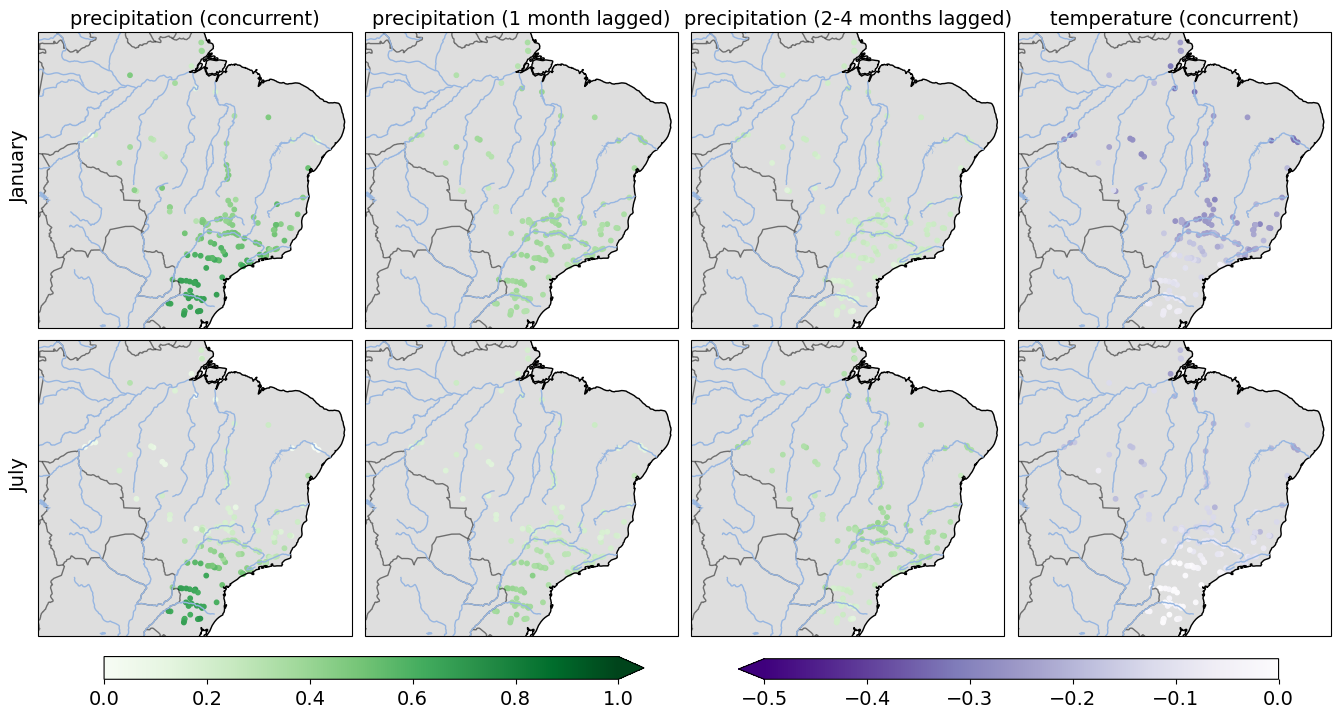

In [12]:
list_plots = []

fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(13.5,7.1))
for i in range(2):
    list_coef = [np.mean(beta1.reshape(nbs,12,4)[:,i*6,:], axis=1), np.mean(beta2.reshape(nbs,12,4)[:,i*6,:], axis=1), np.mean(beta3.reshape(nbs,12,4)[:,i*6,:], axis=1), np.mean(beta4.reshape(nbs,12,4)[:,i*6,:], axis=1)]
    for j in range(4):
        axs[i,j].set_extent(lon_bounds+lat_bounds, crs=ccrs.PlateCarree())
        axs[i,j].add_feature(cfeature.LAND, color="lightgrey", alpha=0.75)
        axs[i,j].add_feature(cfeature.COASTLINE)
        axs[i,j].add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
        axs[i,j].add_feature(cfeature.LAKES, alpha=0.95)
        axs[i,j].add_feature(cfeature.RIVERS)
        if i == 0:
            axs[i,j].set_title(['precipitation (concurrent)','precipitation (1 month lagged)','precipitation (2-4 months lagged)','temperature (concurrent)'][j], fontsize=14)
        if j == 3:
            cmap, vmin, vmax, extend = 'Purples_r', -0.5, 0.0, 'min'
        else:
            cmap, vmin, vmax, extend = 'Greens', 0.0, 1.0, 'max'
        cscatter = axs[i,j].scatter(x=basin_info_df['Lon'], y=basin_info_df['Lat'], c=list_coef[j], cmap=cmap, s=10, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
        if i == 0:
            list_plots.append(cscatter)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.03, right=0.99, wspace=0.03, hspace=0.04)
cax1 = fig.add_axes([0.08, 0.039, 0.4, 0.032])
cbar1 = fig.colorbar(list_plots[0], cax=cax1, orientation='horizontal', extend='max')
ticklabs1 = cbar1.ax.get_xticklabels()
cbar1.ax.set_xticklabels(ticklabs1, fontsize=14)
cax2 = fig.add_axes([0.55, 0.039, 0.4, 0.029])
cbar2 = fig.colorbar(list_plots[3], cax=cax2, orientation='horizontal', extend='min')
ticklabs2 = cbar2.ax.get_xticklabels()
cbar2.ax.set_xticklabels(ticklabs2, fontsize=14)

axs[0,0].text(-0.03, 0.55, 'January', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[0,0].transAxes, fontsize=14)
axs[1,0].text(-0.03, 0.55, 'July', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[1,0].transAxes, fontsize=14)
fig.canvas.draw()

##  4. Fit baseline model and record regression coefficients

In [14]:
inflow_mean = np.mean(inflow, axis=1)
inflow_std = np.std(inflow, axis=1)
y = (inflow-inflow_mean[:,None]) / inflow_std[:,None]       # standardize the prediction target (i.e. inflow)

predictors_mean = np.nanmean(predictors, axis=1)
predictors_std = np.nanstd(predictors, axis=1)
X = np.nan_to_num((predictors - predictors_mean[:,None,:]) / predictors_std[:,None,:], 0.0)
ncm, nyrs, npr = X.shape

coef_prcp_ccr = pd.DataFrame(index=basin_names, columns=months)
coef_prcp_lg1 = pd.DataFrame(index=basin_names, columns=months)
coef_prcp_lg234 = pd.DataFrame(index=basin_names, columns=months)
coef_temp_ccr = pd.DataFrame(index=basin_names, columns=months)

for icm in range(ncm):
    reg_coef = linear_model.LinearRegression(fit_intercept=False).fit(X[icm,:,:], y[icm,:]).coef_.ravel()
    if np.any(np.less(reg_coef*np.array([1.,1.,1.,-1.]),0.)):
        # Set up and solve constrained quadratic optimization problem
        P = matrix(np.dot(X[icm,:,:].T, X[icm,:,:]))
        q = matrix(-np.dot(y[icm,:],X[icm,:,:]).reshape(npr,1))
        G = matrix(np.diag([-1.,-1.,-1.,1.]))
        h = matrix(0.0, (4,1))
        reg_coef = np.array(solvers.qp(P, q, G, h)['x']).ravel()
    coef_prcp_ccr.iloc[basin_id[icm],month_id[icm]] = reg_coef[0]
    coef_prcp_lg1.iloc[basin_id[icm],month_id[icm]] = reg_coef[1]
    coef_prcp_lg234.iloc[basin_id[icm],month_id[icm]] = reg_coef[2]
    coef_temp_ccr.iloc[basin_id[icm],month_id[icm]] = reg_coef[3]

     pcost       dcost       gap    pres   dres
 0: -9.1104e+00 -1.0153e+01  6e+00  2e+00  9e-02
 1: -9.0549e+00 -9.7228e+00  7e-01  3e-16  8e-17
 2: -9.0953e+00 -9.1062e+00  1e-02  2e-16  9e-17
 3: -9.0977e+00 -9.0979e+00  1e-04  1e-16  9e-17
 4: -9.0978e+00 -9.0978e+00  1e-06  6e-17  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0350e+01 -1.1328e+01  6e+00  2e+00  9e-02
 1: -1.0314e+01 -1.0901e+01  9e-01  1e-01  6e-03
 2: -1.0052e+01 -1.0272e+01  2e-01  8e-17  1e-16
 3: -1.0147e+01 -1.0153e+01  6e-03  8e-17  7e-17
 4: -1.0152e+01 -1.0152e+01  6e-05  1e-16  1e-16
 5: -1.0152e+01 -1.0152e+01  6e-07  6e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1211e+01 -1.2277e+01  1e+00  0e+00  8e-02
 1: -1.1214e+01 -1.1226e+01  1e-02  6e-17  8e-04
 2: -1.1214e+01 -1.1215e+01  1e-04  2e-19  8e-06
 3: -1.1214e+01 -1.1214e+01  3e-06  1e-16  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 

##  5. Depict regression coefficients for different months in a map

/tmp/ipykernel_115553/297586149.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_xticklabels(ticklabs1, fontsize=14)
/tmp/ipykernel_115553/297586149.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar2.ax.set_xticklabels(ticklabs2, fontsize=14)


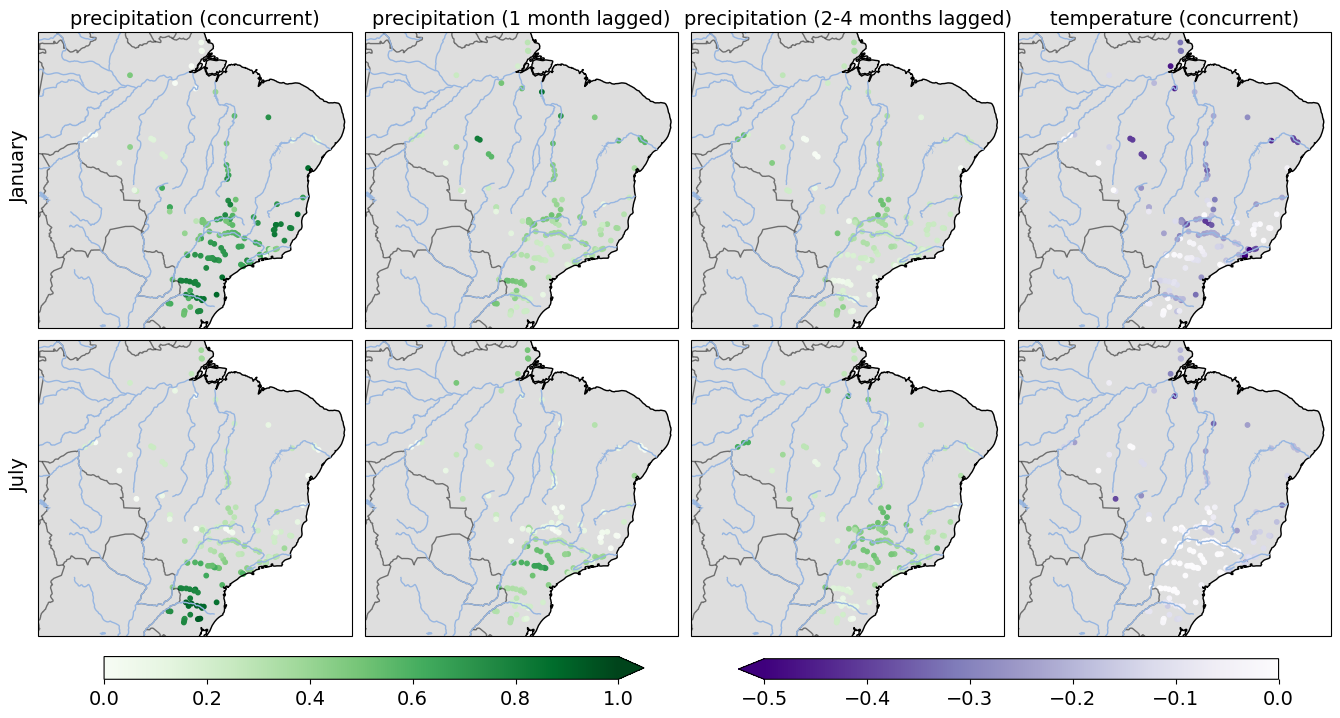

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(13.5,7.1))
for i in range(2):
    month = 1 + i*6
    list_coef = [coef_prcp_ccr[month], coef_prcp_lg1[month], coef_prcp_lg234[month], coef_temp_ccr[month]]
    list_plots = []
    for j in range(4):
        axs[i,j].set_extent(lon_bounds+lat_bounds, crs=ccrs.PlateCarree())
        axs[i,j].add_feature(cfeature.LAND, color="lightgrey", alpha=0.75)
        axs[i,j].add_feature(cfeature.COASTLINE)
        axs[i,j].add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
        axs[i,j].add_feature(cfeature.LAKES, alpha=0.95)
        axs[i,j].add_feature(cfeature.RIVERS)
        if i == 0:
            axs[i,j].set_title(['precipitation (concurrent)','precipitation (1 month lagged)','precipitation (2-4 months lagged)','temperature (concurrent)'][j], fontsize=14)
        if j == 3:
            cmap, vmin, vmax, extend = 'Purples_r', -0.5, 0.0, 'min'
        else:
            cmap, vmin, vmax, extend = 'Greens', 0.0, 1.0, 'max'
        cscatter = axs[i,j].scatter(x=basin_info_df['Lon'], y=basin_info_df['Lat'], c=list_coef[j], cmap=cmap, s=10, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
        if i == 1:
            list_plots.append(cscatter)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.03, right=0.99, wspace=0.03, hspace=0.04)
cax1 = fig.add_axes([0.08, 0.039, 0.4, 0.032])
cbar1 = fig.colorbar(list_plots[0], cax=cax1, orientation='horizontal', extend='max')
ticklabs1 = cbar1.ax.get_xticklabels()
cbar1.ax.set_xticklabels(ticklabs1, fontsize=14)
cax2 = fig.add_axes([0.55, 0.039, 0.4, 0.029])
cbar2 = fig.colorbar(list_plots[3], cax=cax2, orientation='horizontal', extend='min')
ticklabs2 = cbar2.ax.get_xticklabels()
cbar2.ax.set_xticklabels(ticklabs2, fontsize=14)

axs[0,0].text(-0.03, 0.55, 'January', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[0,0].transAxes, fontsize=14)
axs[1,0].text(-0.03, 0.55, 'July', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[1,0].transAxes, fontsize=14)
fig.canvas.draw()